# Model selection

* purpose:   
    * model the relationship between ground truth detection accuracy and unit biological features
    * predict whether a unit's accuracy will be below detection threshold ("dark unit") with fractional logistic regression

Model approach: Data is binomially distributed: y is the number of successes out of N trials. We compute the proportion of successes and fit a binomial GLM.

We used:

- predict accuracy from ground truth units' biological features (not available to experimentalists):
    - unit's true distance to nearest site (to fix)
    - distance [OK]
    - firing_rate  [OK] 
    - signal to noise ratio [OK]  
    - synapse_class [OK]  
    - layers [OK]
    - etypes [OK]  
    - spike spatial extent [OK]
    - unit's soma size [TODO]
    - spike WaveMap shape profile [TODO]

- features available (or that can be approximated) to ephysists, sorted units':    
    - layers [OK]
    - etypes [OK]
    - distance [OK]
    - spike spatial extent [TODO]
    - firing_rate [TODO]
    - synapse_class [TODO]
    - signal-to-noise ratio [TODO]
    - spike WaveMap shape profile [TODO]
    - cell type based on spike temporal duration [TODO]

* Do not add:
    * inh_mini_frequency (only 1 value)
    * morphology (1284 values): not enough instance repeats for robust modeling

* ADD: 
    * Soma size
    * test the model in the evoked regime: how well does it fit. Does it fit better if fitted and tested on evoked data.

### Setup

activate spikeinterf

In [1]:
%load_ext autoreload
%autoreload 2
import os
import spikeinterface as si
import statsmodels.api as sm
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from itertools import combinations, product
from statsmodels.tools.validation import float_like
import warnings
import random

import copy
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)

from src.nodes import utils
from src.nodes.utils import get_config
from src.nodes.metrics import metrics
from src.nodes.metrics.quality import get_scores
from src.nodes.models.Fr import dataloader as fr_dataloader
from src.nodes.models.Fr import utils as fr_utils
from src.nodes.models.Fr.models import FrModel

# SETUP PATHS
data_conf, _ = get_config("silico_neuropixels", "concatenated").values()
KS4 = data_conf["sorting"]["sorters"]["kilosort4"]["10m"]["output"]
GT = data_conf["sorting"]["simulation"]["ground_truth"]["10m"]["output"]
WIRED = data_conf["probe_wiring"]["full"]["output"]
BLUECFG = data_conf["dataeng"]["blueconfig"]
STUDY_FULL = data_conf["postprocessing"]["waveform"]["ground_truth"]["study"]
STUDY = data_conf["postprocessing"]["waveform"]["ground_truth"]["10m"]["study"]
PREP = data_conf["preprocessing"]["full"]["output"]["trace_file_path"]

# parameters
MS_BEFORE = 3
MS_AFTER = 3
DURATION_SEC = 600
DT = 1.3
N_MIN_SPIKES = 10

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.001}
LG_FRAMEON = False              # no legend frame

2024-09-26 12:04:25,213 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-26 12:04:25,262 - root - utils.py - get_config - INFO - Reading experiment config. - done


## (9m)Fr model

**method**:

* fractional regression model (GLM for binomial family with logit link).
* features are z-scored, which accelerated by 2 training convergence.
* main effect (features weights alone) and pairwise interaction weights are trained
* regularized with elasticnet (lasso L1 norm can be set with alpha = 0 else L2 with alpha=1)
    * the function minimized is -loglike/n + alpha*((1-L1\_wt)*|params|_2^2/2 + L1\_wt*|params|_1)
    * we set alpha to 0 and L1\wt to 1 (default) for Lasso, setting small weights to zero (feature selection)
* drop "model_template": values do not have sufficient repeats for cross-validation. The model crashes.
* training convergence:
    * statsmodel does not output the loss function at each iteration, so assessed r-squared convergence for increasing number of iterations [50, 100], and decreasing tolerance[1e-10, 1e-11]. R-squared converged at unit precision with 100 iterations and at a convergence tolerance of 1e-10 .

* best r-squared: 0.42
* the calculation of the r-squared with the pairwise interaction terms is not yet implemented.
    

In [2]:
DATASET = True

# load dataset
if DATASET:
    dataset = fr_dataloader.load_dataset(
        KS4,
        GT,
        PREP,
        STUDY,
        duration_sec=DURATION_SEC,
        n_min_spikes=N_MIN_SPIKES,
    )
    dataset = dataset.drop(columns=["model_template"])
    predictors = dataset.columns.drop(
        [
            "sorting_accuracy",
        ]
    )

# evaluate the model
frmodel = FrModel(predictors, "sorting_accuracy", order=1)
flc_results = frmodel.evaluate(
    dataset=dataset,
    seeds=np.arange(0, 100, 1),
    scale_data=True,
    regularization="elastic_net",
    maxiter=100,
    cnvrg_tol=1e-10,
)
print("model: ", frmodel.formula)
display(flc_results["metric_stats"])

2024-09-26 12:05:51,635 - root - dataloader.py - load_dataset - INFO - CURATION ----------------------------
2024-09-26 12:05:51,638 - root - dataloader.py - load_dataset - INFO - nb of units before filtering by nb of spike: 1388
2024-09-26 12:05:51,643 - root - dataloader.py - load_dataset - INFO - nb after: 1388
2024-09-26 12:05:51,658 - root - dataloader.py - load_dataset - INFO - nb of units before filtering units with inf feature: 1388
2024-09-26 12:05:51,660 - root - dataloader.py - load_dataset - INFO - nb of units after: 1388
model:  sorting_accuracy ~ 1  + firing_rate + synapse_class + bAC + bNAC + bSTUT + cACint + cADpyr + cNAC + cSTUT + dNAC + dSTUT + layer_1 + layer_23 + layer_4 + layer_5 + layer_6 + distance + snr + spatial_extent + exc_mini_frequency + dynamics_holding_current


{'r2_median': 0.42704781075919074,
 'r2_std': 0.03625520269525442,
 'r2_ci95': 0.008260580142783682}

### (9s) Prediction

* Regularized version does report pvalues. As all weight contributed to the predictions (no null), we rerun the fit without regularization to get pvalues.

In [5]:
# instantiate the model
fullfrmodel = FrModel(predictors, "sorting_accuracy", order=1)

# evaluate the model on the full dataset
fullresults = frmodel.evaluate_on_full_dataset(
    dataset=dataset,
    scale_data=True,
    regularization="elastic_net",
    maxiter=100,
    cnvrg_tol=1e-10,
    verbose=False,
)
print("model: ", fullfrmodel.formula)
display(fullresults["metric_data"])

2024-09-26 12:14:34,897 - root - utils.py - evaluate_on_full_dataset - INFO - Z-scoring the dataset features...
2024-09-26 12:14:34,912 - root - utils.py - evaluate_on_full_dataset - INFO - Done Z-scoring.
2024-09-26 12:14:41,728 - root - utils.py - evaluate_on_full_dataset - INFO - Done training the model.
model:  sorting_accuracy ~ 1  + firing_rate + synapse_class + bAC + bNAC + bSTUT + cACint + cADpyr + cNAC + cSTUT + dNAC + dSTUT + layer_1 + layer_23 + layer_4 + layer_5 + layer_6 + distance + snr + spatial_extent + exc_mini_frequency + dynamics_holding_current


{'model': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7ffe3e622580>,
 'r-squared': 0.43493565124894973}

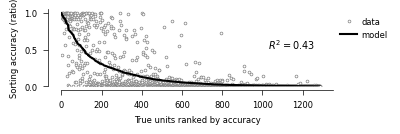

In [21]:
# FIGURE SETTINGS
MARKEREDGEWIDTH = 0.5
ALPHA = 1
LINEWIDTH = 1.5
MARKERSIZE = 2

# compute predictions
fullmodel = fullresults["metric_data"]["model"]
weights = fullmodel.params
prediction = fullmodel.model.predict(weights)

# add prediction to dataset
dataset2 = copy.copy(dataset)
dataset2 = dataset2.dropna()
dataset2["prediction"] = prediction

# sort
df_sorted = dataset2.sort_values(by="prediction", ascending=False)

# plot
fig, ax = plt.subplots(1, figsize=(3.5, 1))
ax.plot(
    df_sorted["sorting_accuracy"].values,
    "o",
    color="w",
    markeredgecolor=(0.5, 0.5, 0.5),
    markeredgewidth=MARKEREDGEWIDTH,
    markersize=MARKERSIZE,
    label="data",
    alpha=ALPHA,
)
ax.plot(
    df_sorted["prediction"].values,
    "-",
    color=(0, 0, 0),
    linewidth=LINEWIDTH,
    label="model",
)

# annotate cross-validated r-squared
r2 = np.round(flc_results["metric_stats"]["r2_median"], 2)
ax.annotate(
    text=f"$R^2=${r2}",
    xy=(0.8 * dataset2.shape[0], 0.5),
    color="k",
    fontsize=7,
)

# aesthetics
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_xlabel("True units ranked by accuracy")
ax.set_ylabel("Sorting accuracy (ratio)")
ax.legend(**legend_cfg, bbox_to_anchor=(1, 1), loc="upper left")

# disconnect axes (R style)
ax.spines[["right", "top"]].set_visible(False)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["right"].set_visible(False)


# save
utils.savefig("figures/2_causes/assets/fig6C_prediction_NS_ks4.svg")

### Weights

In [7]:
def interpret_features_weights(model_results):

    # build table of features contributions  ---------------
    weights = model_results.params

    # add feature weights
    weights_for_df = weights.drop(index="Intercept")
    weights_df = weights_for_df.to_frame()
    weights_df.columns = ["weights"]

    # add p-values (fit to entire dataset)
    pvalues_df = model_results.pvalues.drop(index="Intercept")
    pvalues_df = pvalues_df.to_frame()
    pvalues_df.columns = ["p-value"]
    data_df = pd.merge(
        weights_df,
        pvalues_df,
        left_index=True,
        right_index=True,
    )

    # interpret interceptsl
    print("Intercept:")
    print("- logodds of detected HQ units:", weights["Intercept"])
    odds = np.exp(weights["Intercept"])
    print(
        "- P(Identified HQ units when all features are null):",
        odds / (1 + odds),
    )

    # interpret all features
    odds = np.exp(weights["Intercept"] + data_df["weights"])
    data_df[r"\Delta accuracy"] = np.sign(data_df["weights"]) * odds / (1 + odds)

    # display
    data_df = data_df.sort_values(by=["weights"], ascending=False)
    return data_df

Intercept:
- logodds of detected HQ units: -2.950822663461246
- P(Identified HQ units when all features are null): 0.049697644586457736


,weights,p-value,\Delta accuracy
firing_rate,0.905848,2.422626e-17,0.114561
spatial_extent,0.520868,2.466741e-07,0.080917
layer_5,0.398473,1.895358e-05,0.072269
synapse_class,0.200746,2.275729e-03,0.060082
cADpyr,0.200746,2.275729e-03,0.060082
layer_4,0.109131,2.885412e-01,0.055112
cACint,0.092719,3.701631e-01,0.054264
dynamics_holding_current,0.060810,6.463635e-01,0.052649
dSTUT,-0.083132,7.665134e-01,-0.045915
layer_1,-0.085247,8.708741e-01,-0.045823


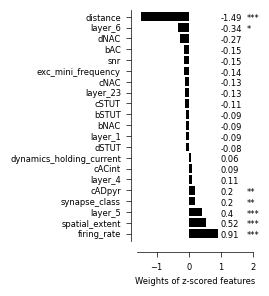

In [20]:
table_data = interpret_features_weights(fullresults["metric_data"]["model"])
display(table_data)

# plot
fig, ax = plt.subplots(1, 1, figsize=(1.5, 3))

# plot
ax = table_data.plot.barh(ax=ax, y="weights", color="k", width=0.8)

for ix in range(len(table_data["weights"])):
    text = ""
    if (table_data["p-value"].iloc[ix] < 0.05) and (
        table_data["p-value"].iloc[ix] >= 0.01
    ):
        text = "*"
    elif (table_data["p-value"].iloc[ix] < 0.01) and (
        table_data["p-value"].iloc[ix] >= 0.001
    ):
        text = "**"
    elif table_data["p-value"].iloc[ix] < 0.001:
        text = "***"
    ax.annotate(
        text=text,
        xy=(
            1.8,
            ix - 0.4,
        ),
    )
    ax.annotate(
        text=np.round(table_data["weights"].iloc[ix], 2),
        xy=(
            1,
            ix - 0.4,
        ),
    )
# aesthetics
ax.set_xlim([ax.get_xlim()[0], 2])
ax.spines[["right", "top"]].set_visible(False)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["right"].set_visible(False)

# no legend
ax.legend().set_visible(False)
ax.set_xlabel("Weights of z-scored features")

utils.savefig("figures/2_causes/assets/fig6D_weights_frmodel_NS_ks4.svg")

In [19]:
table_data.index

Index(['firing_rate', 'spatial_extent', 'layer_5', 'synapse_class', 'cADpyr',
       'layer_4', 'cACint', 'dynamics_holding_current', 'dSTUT', 'layer_1',
       'bNAC', 'bSTUT', 'cSTUT', 'layer_23', 'cNAC', 'exc_mini_frequency',
       'snr', 'bAC', 'dNAC', 'layer_6', 'distance'],
      dtype='object')

### References

https://github.com/statsmodels/statsmodels/issues/9048
https://www.statsmodels.org/dev/examples/notebooks/generated/quasibinomial.html

https://www3.nd.edu/~rwilliam/stats3/L05.pdf

Mcfadden pseudo R2 equation:  
https://timeseriesreasoning.com/contents/r-squared-adjusted-r-squared-pseudo-r-squared/#:~:text=McFadden%27s%20Pseudo%2DR²%20is%20implemented,your%20fitted%20nonlinear%20regression%20model.

Mcfadden pseudo R2 interpretation (between 0.2 and 0.4 indicates excellent fit)  
https://stats.stackexchange.com/questions/82105/mcfaddens-pseudo-r2-interpretation

https://datascience.oneoffcoder.com/psuedo-r-squared-logistic-regression.html

https://stats.stackexchange.com/questions/386675/what-are-weights-in-a-binary-glm-and-how-to-calculate-them

https://stackoverflow.com/questions/72329673/binomial-glm-in-r-what-do-the-coefficients-talk-about
* **interpret weights**